In [1]:
# Import Libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Load the Dataset
df = pd.read_csv("acf.csv", encoding='latin1')

In [4]:
# Drop rows with missing 'Summary' data
df = df.dropna(subset=['Summary'])

### Probable Causes

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer  # For stemming
import string

# Download NLTK resources if needed
nltk.download('punkt')
nltk.download('stopwords')

# Customized stopword list with aviation-related terms
stopwords_aviation = set(stopwords.words('english')).union({'aircraft', 'flight', 'pilot', 'airplane', 'airport', 'engine', 'wing', 'system'})

# Tokenization function with stemming
def process_text(text):
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords and punctuation
    tokens = [word.lower() for word in tokens if word.isalpha() and word not in stopwords_aviation]
    # Apply stemming (optional)
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]
    return tokens

# Apply tokenization to 'Summary' column
df['Processed Summary'] = df['Summary'].apply(process_text)

In [7]:
from collections import Counter
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures  # For bigram analysis

# Flatten the list of processed tokens
all_words = [word for summary in df['Processed Summary'] for word in summary]

# Analyze bigrams (optional)
bigram_measures = BigramAssocMeasures()
bigram_finder = BigramCollocationFinder.from_words(all_words)
bigrams = bigram_finder.nbest(bigram_measures.likelihood_ratio, 20)  # Get top 20 bigrams

# Calculate word frequencies
word_freq = Counter(all_words + [' '.join(bigram) for bigram in bigrams])  # Include bigrams

# Get the most common probable causes (words or bigrams)
most_common_causes = word_freq.most_common(10)

# Display the most common probable causes
print("Top 10 Most Common Probable Causes of Airplane Incidents:")
for cause, frequency in most_common_causes:
    print(f"{cause}: {frequency} occurrences")

Top 10 Most Common Probable Causes of Airplane Incidents:
the: 4762 occurrences
crash: 3667 occurrences
plane: 2303 occurrences
land: 1490 occurrences
crew: 1127 occurrences
approach: 1060 occurrences
runway: 1047 occurrences
failur: 850 occurrences
attempt: 834 occurrences
control: 772 occurrences


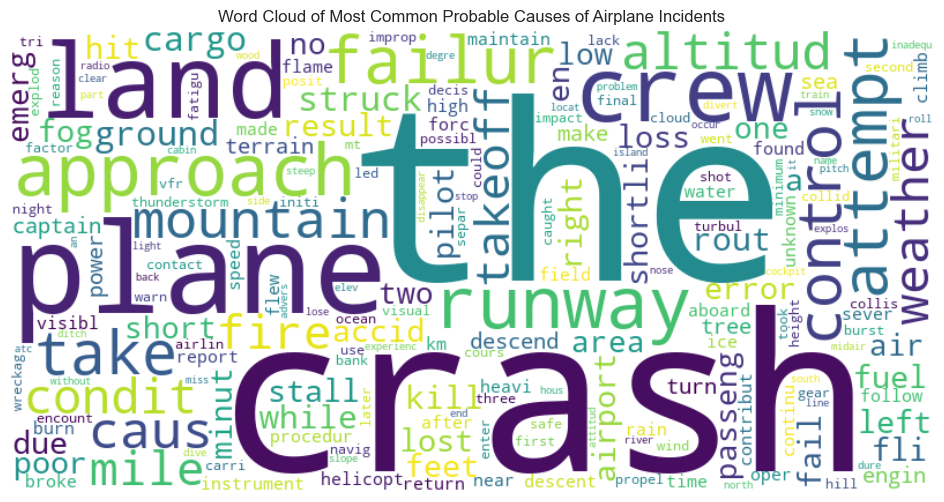

interactive(children=(IntSlider(value=1, description='min_freq', max=3, min=-1), Output()), _dom_classes=('wid…

In [9]:
from wordcloud import WordCloud

# Create a word cloud with interactive features
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Most Common Probable Causes of Airplane Incidents')

# Add interactive features (example using ipywidgets for Jupyter Notebook)
from ipywidgets import interact

@interact
def filter_wordcloud(min_freq=1):
    wordcloud.generate_from_frequencies({word: freq for word, freq in word_freq.items() if freq >= min_freq})
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud of Most Common Probable Causes (min_freq={})'.format(min_freq))
    plt.show()

### Temporal Analysis of Probable Causes

In [10]:
# Ensure consistent time zone (assuming UTC for this example)
df['Date'] = pd.to_datetime(df['Date']).dt.tz_localize('UTC')

# Handle missing or invalid dates (example using exclusion)
df = df.dropna(subset=['Date'])
df = df[df['Date'].notna()]

In [11]:
# Group by year and aggregate processed summaries
yearly_processed_summaries = df.groupby(df['Date'].dt.year)['Processed Summary'].agg(lambda x: [word for summary in x for word in summary])

# Example of alternative grouping (by decade)
decadal_processed_summaries = df.groupby(df['Date'].dt.year // 10 * 10)['Processed Summary'].agg(lambda x: [word for summary in x for word in summary])

In [12]:
from collections import Counter

# Calculate word frequencies for each year
yearly_word_freq = yearly_processed_summaries.apply(lambda x: Counter(x))

# Calculate relative frequencies for each year (example)
yearly_relative_freq = yearly_word_freq.apply(lambda x: {word: freq / sum(x.values()) for word, freq in x.items()})

In [13]:
# Get the most common probable causes for each year
most_common_causes_by_year = yearly_word_freq.apply(lambda x: x.most_common(5))

# Track emerging or declining causes (example)
emerging_causes = []
declining_causes = []
for year, freq in yearly_relative_freq.items():
    for cause, freq_year in freq.items():
        if freq_year > 0.05 and cause not in emerging_causes:  # Example threshold for emerging causes
            emerging_causes.append(cause)
        if freq_year < 0.01 and cause in emerging_causes:  # Example threshold for declining causes
            declining_causes.append(cause)

In [18]:
for year, freq in yearly_word_freq.items():
    print(f"Most common words in {year}: {freq.most_common(5)}")

Most common words in 1908: [('orvil', 2), ('wright', 2), ('selfridg', 2), ('suffer', 2), ('dure', 1)]
Most common words in 1909: [('air', 2), ('eugen', 1), ('lefebvr', 1), ('first', 1), ('ever', 1)]
Most common words in 1912: [('first', 1), ('dirig', 1), ('akron', 1), ('explod', 1), ('offshor', 1)]
Most common words in 1913: [('the', 3), ('airship', 2), ('first', 1), ('fatal', 1), ('accid', 1)]
Most common words in 1915: [('crash', 1), ('tree', 1), ('attempt', 1), ('land', 1), ('shot', 1)]
Most common words in 1916: [('crash', 4), ('shot', 3), ('british', 3), ('sea', 2), ('flame', 2)]
Most common words in 1917: [('shot', 4), ('fire', 3), ('crash', 3), ('british', 3), ('sea', 2)]
Most common words in 1918: [('crash', 2), ('shot', 2), ('british', 2), ('plane', 2), ('feet', 2)]
Most common words in 1919: [('crash', 7), ('the', 5), ('plane', 4), ('mail', 3), ('land', 3)]
Most common words in 1920: [('crash', 18), ('the', 8), ('plane', 7), ('land', 6), ('while', 5)]
Most common words in 192

In [19]:
# Group by year and aggregate processed summaries
yearly_processed_summaries = df.groupby(df['Date'].dt.year)['Processed Summary'].agg(lambda x: [word for summary in x for word in summary])


In [20]:
from collections import Counter

# Calculate word frequencies for each year
yearly_word_freq = yearly_processed_summaries.apply(lambda x: Counter(x))

In [21]:
# Get the most common probable causes for each year
most_common_causes_by_year = yearly_word_freq.apply(lambda x: x.most_common(5))

# Display the most common probable causes for each year
for year, causes in most_common_causes_by_year.items():
    print(f"\nTop 5 Most Common Probable Causes of Airplane Incidents in {year}:")
    for cause, frequency in causes:
        print(f"{cause}: {frequency} occurrences")


Top 5 Most Common Probable Causes of Airplane Incidents in 1908:
orvil: 2 occurrences
wright: 2 occurrences
selfridg: 2 occurrences
suffer: 2 occurrences
dure: 1 occurrences

Top 5 Most Common Probable Causes of Airplane Incidents in 1909:
air: 2 occurrences
eugen: 1 occurrences
lefebvr: 1 occurrences
first: 1 occurrences
ever: 1 occurrences

Top 5 Most Common Probable Causes of Airplane Incidents in 1912:
first: 1 occurrences
dirig: 1 occurrences
akron: 1 occurrences
explod: 1 occurrences
offshor: 1 occurrences

Top 5 Most Common Probable Causes of Airplane Incidents in 1913:
the: 3 occurrences
airship: 2 occurrences
first: 1 occurrences
fatal: 1 occurrences
accid: 1 occurrences

Top 5 Most Common Probable Causes of Airplane Incidents in 1915:
crash: 1 occurrences
tree: 1 occurrences
attempt: 1 occurrences
land: 1 occurrences
shot: 1 occurrences

Top 5 Most Common Probable Causes of Airplane Incidents in 1916:
crash: 4 occurrences
shot: 3 occurrences
british: 3 occurrences
sea: 2 occ

In [23]:
# Get the most common probable causes for each year
most_common_causes_by_year = yearly_word_freq.apply(lambda x: x.most_common(5))

# Display the most common probable causes for each year
for year, causes in most_common_causes_by_year.items():
    print(f"\nTop 5 Most Common Probable Causes of Airplane Incidents in {year}:")
    for cause, frequency in causes:
        print(f"{cause}: {frequency} occurrences")


Top 5 Most Common Probable Causes of Airplane Incidents in 1908:
orvil: 2 occurrences
wright: 2 occurrences
selfridg: 2 occurrences
suffer: 2 occurrences
dure: 1 occurrences

Top 5 Most Common Probable Causes of Airplane Incidents in 1909:
air: 2 occurrences
eugen: 1 occurrences
lefebvr: 1 occurrences
first: 1 occurrences
ever: 1 occurrences

Top 5 Most Common Probable Causes of Airplane Incidents in 1912:
first: 1 occurrences
dirig: 1 occurrences
akron: 1 occurrences
explod: 1 occurrences
offshor: 1 occurrences

Top 5 Most Common Probable Causes of Airplane Incidents in 1913:
the: 3 occurrences
airship: 2 occurrences
first: 1 occurrences
fatal: 1 occurrences
accid: 1 occurrences

Top 5 Most Common Probable Causes of Airplane Incidents in 1915:
crash: 1 occurrences
tree: 1 occurrences
attempt: 1 occurrences
land: 1 occurrences
shot: 1 occurrences

Top 5 Most Common Probable Causes of Airplane Incidents in 1916:
crash: 4 occurrences
shot: 3 occurrences
british: 3 occurrences
sea: 2 occ